In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp
import autokeras as ak

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

tfd = tfp.distributions
tfpl = tfp.layers
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

#rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]
from joblib import Parallel, delayed

## Reading and preparing data

In [85]:
df = pd.read_csv("../data/processed/train.csv") 
df.head(n=5)  # visualize the data.

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [86]:
df_fault_number = df.faultNumber.drop_duplicates()
df_fault_number.shape



(21,)

In [87]:
# Remove simulation columns
df = df.drop(['simulationRun', 'sample', 'Unnamed: 0'], axis=1)
#ignore the hard to detect faults
# aus welchem Grund haste 3,9,15 aus acht gelassen
#df = df.drop(df[(df.faultNumber == 3) | (df.faultNumber == 9) | (df.faultNumber == 15)].index).reset_index()
#make label binary
df.loc[df['faultNumber'] > 0, 'faultNumber'] = 1


In [88]:
#balance classes
df = df[df['faultNumber']!=0].sample(n=len(df[df['faultNumber']==0])).append(df[df['faultNumber']==0])
df

,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
893551,1.0,0.115860,3696.6,4543.3,9.2589,26.807,42.652,2674.5,74.455,120.40,...,53.989,11.600,61.972,23.716,35.911,38.477,45.305,45.415,41.242,15.719
1962538,1.0,0.000907,3682.6,4450.8,9.4544,27.224,41.922,2714.1,73.203,120.42,...,53.969,91.264,65.795,19.102,42.510,42.927,49.641,45.063,40.581,19.062
346280,1.0,0.178540,3691.4,4538.5,9.2922,26.952,42.100,2811.3,77.040,120.43,...,53.936,17.654,58.237,25.510,32.815,36.559,46.383,83.327,40.911,19.006
2904641,1.0,0.283000,3706.2,4592.7,9.2267,26.723,42.515,2703.0,75.732,120.42,...,53.394,27.762,59.957,21.388,41.211,40.202,45.866,49.641,41.211,18.279
5086828,1.0,0.223610,3676.8,4476.9,9.4144,26.962,42.276,2699.1,74.443,120.33,...,53.594,22.522,60.763,21.964,39.994,41.952,44.530,51.156,39.567,18.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.0,0.293250,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,120.41,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,0.0,0.291340,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,120.39,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,0.0,0.294380,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,120.41,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,0.0,0.252690,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,120.39,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


# Prepare data for LSTM models

In [89]:
input_X = df.loc[:, df.columns != 'faultNumber'].values  # converts the df to a numpy array
input_y = df['faultNumber'].values

n_features = input_X.shape[1]  # number of features

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),test_size=0.33, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_test, y_test, test_size=DATA_SPLIT_PCT, random_state=2)


In [90]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [91]:
lookback = 5  # Equivalent to 15 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

### Divide the data into train, valid, and test

In [92]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_test, y_test, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [93]:
X_train.shape

(79999, 5, 1, 52)

In [94]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train!=0] #any fault

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid!=0] #any fault

In [95]:
print(X_valid_y0.shape)
print(X_valid_y1.shape)

(9972, 5, 1, 52)
(10028, 5, 1, 52)


#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [96]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

### Standardize the data

In [97]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [98]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [99]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [100]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

Initialize v1 of the autoencoder architecture. More experimentation possible

In [101]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 52

epochs = 8
batch = 512
lr = 0.01
num_inducing_points = n_features

# AUTOML

In [102]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node1 = ak.ConvBlock()(output_node)
#output_node2 = ak.ResNetBlock(version="v1")(output_node)
#output_node = ak.Merge()([output_node1, output_node2])
output_node = ak.ClassificationHead()(output_node1)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1)

In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.Merge()([output_node1, output_node2])
output_node = ak.ClassificationHead()(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)


auto_model.fit(X_train, y_train, epochs=1)
# Predict with the best model.
predicted_y = auto_model.predict(X_test)

Trial 1 Complete [00h 16m 38s]
val_loss: 0.07935873419046402

Best val_loss So Far: 0.07935873419046402
Total elapsed time: 00h 16m 38s
INFO:tensorflow:Oracle triggered exit
2500/2500 [==============================] - 1194s 476ms/step - loss: 0.0621 - accuracy: 0.9814
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score

false_pos_rate, true_pos_rate, thresholds = roc_curve( y_test , predicted_y)

roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
precision_m( tf.dtypes.cast(y_valid, tf.float32) ,y_pred)

In [74]:
y_pred = auto_model.predict(X_valid)

Define the trainable prior and posterior distributions to estimate uncertainties

Train: 0.040, Test: 0.041


AttributeError: 'NoneType' object has no attribute 'history'

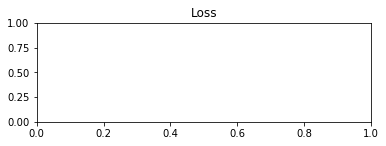

In [29]:
from matplotlib import pyplot

_, train_acc = auto_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = auto_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
history['loss']

TypeError: 'NoneType' object is not subscriptable

In [19]:
input_shape=(timesteps, n_features)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(timesteps), scale=1),
                        reinterpreted_batch_ndims=1)
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(128, input_shape=input_shape, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(64, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(32, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(16, return_sequences=False))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
#helper layer to get the right shape for tfp layer
lstm_autoencoder.add(Dense(tfpl.MultivariateNormalTriL.params_size(timesteps),
                       activation=None))
lstm_autoencoder.add(tfpl.MultivariateNormalTriL(
                        timesteps,
                        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)))

lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder.add(LSTM(16, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(32, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(64, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(128, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
#lstm_autoencoder.add (Dense(n_features, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
# bring the output into a time distributed shape
#lstm_autoencoder.add(tfpl.DenseVariational(n_features, posterior_mean_field, prior_trainable)) 
# mathematically like a Dense Layer but with distributions 

#helper layer to get the right shape for tfp layer
lstm_autoencoder.add(Dense(tfpl.IndependentNormal.params_size(n_features),
                       activation=None))

lstm_autoencoder.add(tfpl.IndependentNormal(n_features))
# returns n_features independent normal distributions.
# note: an Autoencoder tries to "recreate" the input

lstm_autoencoder.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            93184     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
___________________________________

In [20]:
adam = optimizers.Adam(lr)

#neg loglikelihood for well defined covariance matrices
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
lstm_autoencoder.compile(loss=negative_log_likelihood, optimizer=adam)

cp = ModelCheckpoint(filepath="variational_autoencoder_dropout2.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1).history

Epoch 1/8
78/78 [==============================] - 12s 156ms/step - loss: 76.1179 - val_loss: 75.1697
Epoch 2/8
78/78 [==============================] - 10s 129ms/step - loss: 75.2262 - val_loss: 75.1796
Epoch 3/8
78/78 [==============================] - 10s 130ms/step - loss: 75.2219 - val_loss: 75.1759
Epoch 4/8
78/78 [==============================] - 10s 130ms/step - loss: 75.2212 - val_loss: 75.1856
Epoch 5/8
78/78 [==============================] - 10s 131ms/step - loss: 75.2191 - val_loss: 75.1777
Epoch 6/8
78/78 [==============================] - 10s 130ms/step - loss: 75.2174 - val_loss: 75.1729
Epoch 7/8
78/78 [==============================] - 10s 131ms/step - loss: 75.2164 - val_loss: 75.1701
Epoch 8/8
78/78 [==============================] - 10s 131ms/step - loss: 75.2127 - val_loss: 75.1782


$\text{ELBO}(x)=\int \space \text{d}z \space q(z|x) \space \text{log}p(x|z) \space + \space \int \space \text{d}z \space q(z|x) \frac{q(z|x)}{p(z)}$

$p(z)$, the prior on the latent representation z,

$q(z|x)$, the variational encoder

$p(x|z)$, the decoder — how likely is the image x given the latent representation z.

The first integral in the ELBO equation is the reconstruction term. It asks how likely we are to start at an image x, encode it to z, decode it, and get back the original x

In [21]:
#lstm_autoencoder.save('../models/LSTM_Variational_Autoencoder_dropout2')

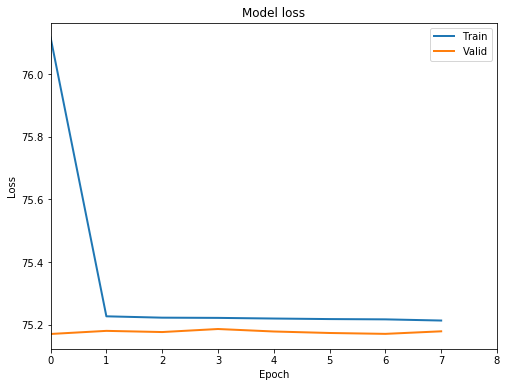

In [22]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
#plt.ylim(2.5,4)
plt.xlim(0,epochs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

why does the loss keep going down? higher training rate? just the nature of loglikelihood?

In [23]:
#lstm_autoencoder = tf.keras.models.load_model(
#    '../models/LSTM_Autoencoder_prob_128', custom_objects=None, compile=True
#)

## Predictions using the Autoencoder
    - test for all faults
    - test for performance on individual faults "only fault n"
    - different cuts for different faults?

Draw n-times for the validation data set

every forward pass draws from the final distribution

this is computationally expensive but we get a posterior distribution to evaluate

in production there would be a smaller window used so computation time is significantly lower

In [24]:
n_vals = 10
yhats = [lstm_autoencoder.predict(X_valid_scaled) for _ in range(n_vals)]

use the predictions like an ensemble

In [25]:
#average over all predictions 
avg = np.squeeze(yhats).mean(axis=0)
std = np.squeeze(yhats).std(axis=0)
print(np.shape(avg))

#calculate some regression metrics
mse = np.mean(np.power(flatten(X_valid_scaled)-flatten(avg),2),axis=1)
print(mse)
chi2 = np.sum(np.power(flatten(X_valid_scaled)-flatten(avg),2)/flatten(std), axis=1)
print(chi2)
wmse = np.mean(np.power((flatten(X_valid_scaled)-flatten(avg))/flatten(std),2),axis=1)
print(wmse)
avgstd = np.mean(flatten(std),axis=1)
print(avgstd)

y_valid[y_valid!=0] = 1
error_df = pd.DataFrame({'MSE': mse,
                         'Weighted MSE': wmse,
                         'Chi2': chi2,
                         'AVGSTD': avgstd,                         
                         'True_class': y_valid.tolist()})

error_df.to_csv('error_df.csv')

(20000, 5, 53)
[ 1.5279457   0.98549307  0.86297134 ...  0.99447929 96.34683592
 33.53737583]
[  93.88320495   57.28741653   52.00395583 ...   65.92149503 6566.17134471
 2231.54075216]
[  2.19501679   1.2540853    1.15163601 ...   1.66037423 159.51104227
  53.49218576]
[0.93124291 0.90117415 0.92880257 ... 0.91141906 0.94913444 0.89934563]


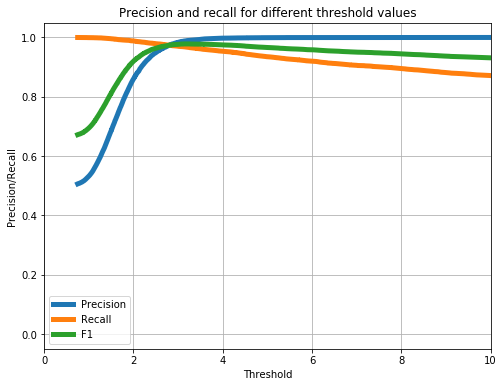

In [26]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Weighted MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()
plt.show()

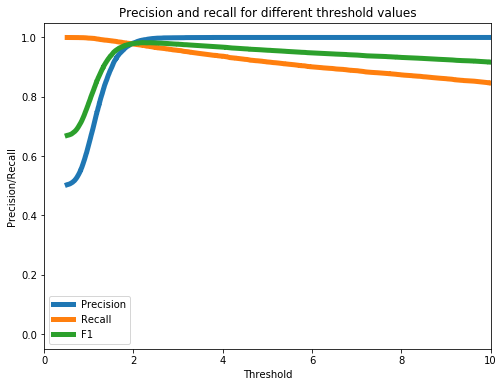

In [27]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

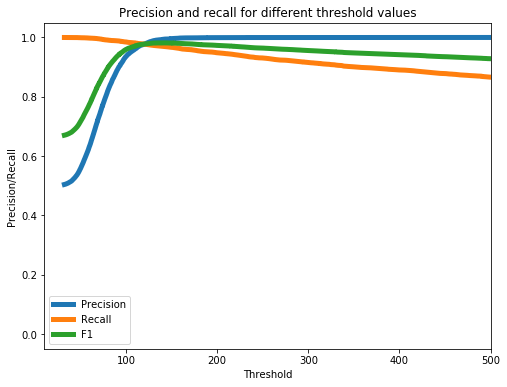

In [28]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Chi2'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(10,500)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

<ipython-input-29-753680ebff6b>:2: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)


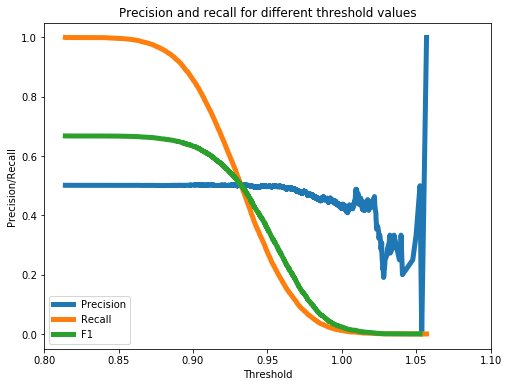

In [29]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['AVGSTD'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0.8,1.10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

choose a threshold by eye looking at the scores

In [30]:
threshold_fixed = 2.3
pred_y = [0 if e < threshold_fixed else 1 for e in error_df['Weighted MSE'].values]

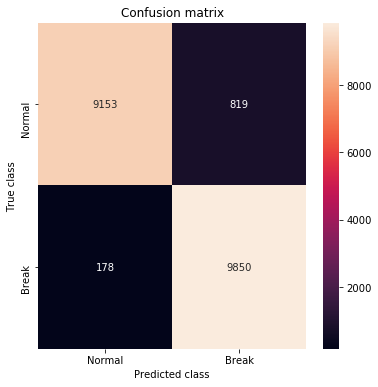

In [31]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

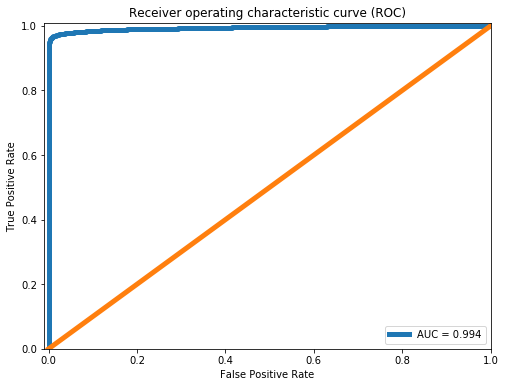

In [32]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df['Weighted MSE'])
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Do this for all different faults?

Or train another LSTM on top that does the classification

In [33]:
def evaluate_performance(X_valid_scaled, fault, n_vals=10):
    X = X_valid_scaled[(y_valid==0)|(y_valid==fault)]   
    yhats = [lstm_autoencoder.predict(X) for _ in range(n_vals)]
    #average over all predictions 
    avg = np.squeeze(yhats).mean(axis=0)
    std = np.squeeze(yhats).std(axis=0)

    mse = np.mean(np.power(flatten(X)-flatten(avg),2),axis=1)
    print(mse)
    chi2 = np.sum(np.power(flatten(X)-flatten(avg),2)/flatten(std), axis=1)
    print(chi2)
    wmse = np.mean(np.power((flatten(X)-flatten(avg))/flatten(std),2),axis=1)
    print(len(wmse))
    y = np.zeros_like(y_valid)
    y[y_valid==fault] = 1
    print(len(y))
    error_df = pd.DataFrame({'MSE': mse,
                             'Weighted MSE': wmse,
                             'Chi2': chi2,
                              'True_class': y.tolist()})
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Weighted MSE'])
    F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
    plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
    plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
    plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
    plt.xlim(0.5,10)
    plt.title('Precision and recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.show()
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df['Weighted MSE'])
    roc_auc = auc(false_pos_rate, true_pos_rate,)

    plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)

    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[ 1.56546055  0.95231856  0.86014732 ...  1.08297833 95.5665819
 33.13309293]
[  99.95729724   57.60874553   52.03177404 ...   61.2753765  4921.41592894
 2050.55204072]
20000
20000


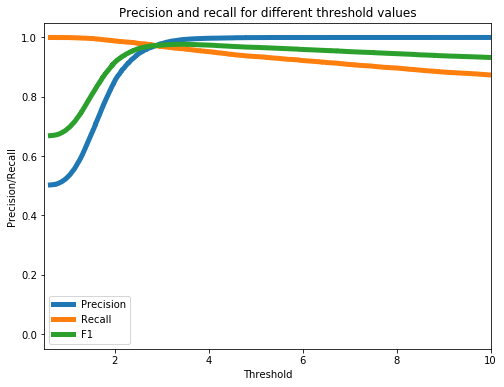

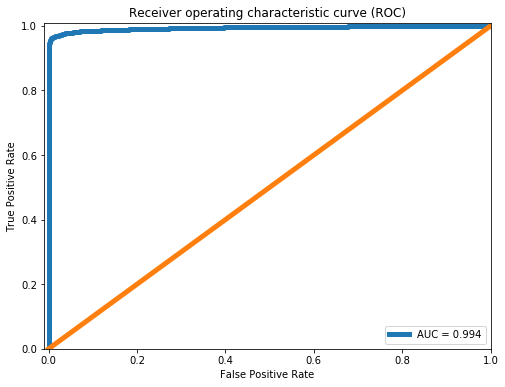

In [34]:
evaluate_performance(X_valid_scaled, 1, n_vals=10)

In [ ]:
[evaluate_performance(X_valid_scaled, i, n_vals=10) for i in np.unique(y_valid)]